In [1]:
import cupy as cp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
import pickle
import sys


sys.path.append(os.path.join(os.getenv("HOME"), "gpuaffman_networks/"))
import general_network_visualization, ragged_general_network
from genetics import analysis_util, tasks

In [2]:
plt_save_dir = "/home/trevor/boolean_network_data/plots_and_misc_material"

In [3]:
k8_data = ["boolean_network_data/and_evolution_results/2023-02-14-12-05-04"]
k3_data = ["boolean_network_data/and_evolution_results/2023-02-16-10-00-25"]
k2_data = ["boolean_network_data/and_evolution_results/2023-02-16-09-08-22", "boolean_network_data/and_evolution_results/2023-02-16-04-46-06",
           "boolean_network_data/and_evolution_results/2023-02-16-03-59-58"]

In [4]:
data_src = k3_data

In [5]:
populations = []
for src in data_src:
    data_dir = os.path.join(os.getenv("HOME"), src)
    best_error = np.load(os.path.join(data_dir, "best_errors.npy"))
    with open(os.path.join(data_dir,"best_populations.pk"), "rb") as f:
        populations += pickle.load(f)


In [6]:
N = populations[0][0].shape[0]
input_state = cp.asnumpy(tasks.make_2_bit_input_state(N))
batched_input_state = np.broadcast_to(np.expand_dims(np.expand_dims(input_state, 1), 1), (input_state.shape[0], len(populations), 1, N)).astype(np.bool_)
best_functions = np.expand_dims(np.stack([x[0] for x in populations], axis=0), 1).astype(np.bool_)
best_conn = np.expand_dims(np.stack([x[1] for x in populations], axis=0), 1).astype(np.int16)
best_used_conn = np.expand_dims(np.stack([x[2] for x in populations], axis=0), 1).astype(np.bool_)

In [8]:
best_functions, best_conn, best_used_conn, sorted_perfs, _ =  analysis_util.sort_by_performance(batched_input_state, best_functions, best_conn, best_used_conn, tasks.evaluate_and_task)

In [1]:
graphs = [general_network_visualization.influence_graph_from_ragged_spec(f[0, :, :], c[0, :, :], uc[0, :, :]) for f, c, uc in zip(best_functions, best_conn, best_used_conn)]


NameError: name 'best_functions' is not defined

In [2]:
import importlib
importlib.reload(general_network_visualization)
best_to_plot = 3
to_plot = graphs[:best_to_plot]
fig, axs = plt.subplots(ncols=len(to_plot), figsize=(10,5))
node_colors = ["C0"] * N
node_colors[0] = "C1"
node_colors[1] = "C1"
node_colors[2] = "C2"


for i, (g, ax, err) in enumerate(zip(graphs, axs, sorted_perfs[:best_to_plot])):
    pos = nx.spring_layout(g, iterations=10)
    colorbar = True if i==best_to_plot-1 else False
    general_network_visualization.plot_network_directed(g, pos, ax, node_colors, colorbar=colorbar)
    ax.set_title("Logical Error Rate: {:.2E}".format(err))
plt.savefig(os.path.join(plt_save_dir, "and_organisms.png"), dpi=400)
fig.tight_layout()

NameError: name 'general_network_visualization' is not defined

In [31]:
example_trajs, example_noise = analysis_util.run_dynamics_forward_save_state(batched_input_state, best_functions, best_conn, best_used_conn, 20, 0.02)
example_trajs = np.squeeze(example_trajs, -2)
example_noise = np.squeeze(example_noise, -2)

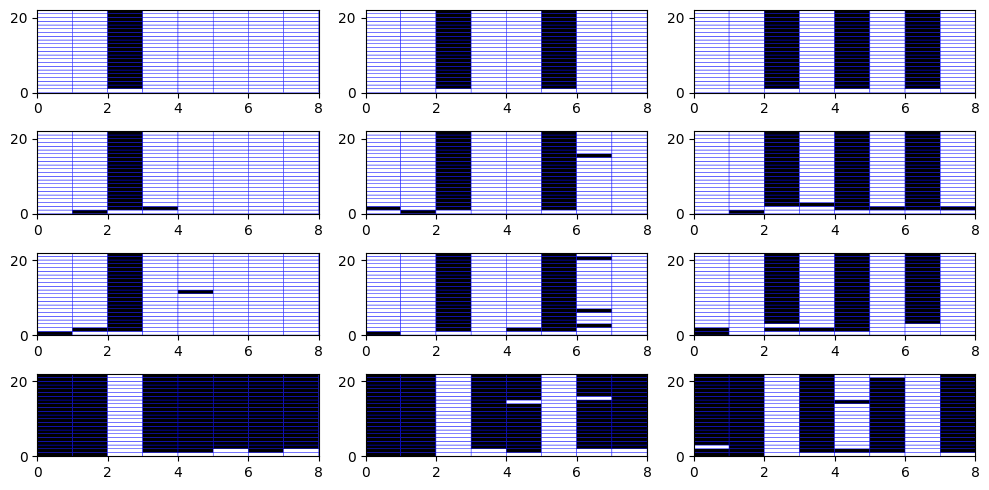

In [32]:
fig, axs = plt.subplots(nrows=4, ncols=best_to_plot, figsize=(10, 5))
for i in range(best_to_plot):
    axs[0, i].pcolor(example_trajs[:, 0, i, :], cmap="Greys", linewidth=0.3, edgecolors="blue")
    axs[1, i].pcolor(example_trajs[:, 1, i, :], cmap="Greys", linewidth=0.3, edgecolors="blue")
    axs[2, i].pcolor(example_trajs[:, 2, i, :], cmap="Greys", linewidth=0.3, edgecolors="blue")
    axs[3, i].pcolor(example_trajs[:, 3, i, :], cmap="Greys", linewidth=0.3, edgecolors="blue")
fig.tight_layout()

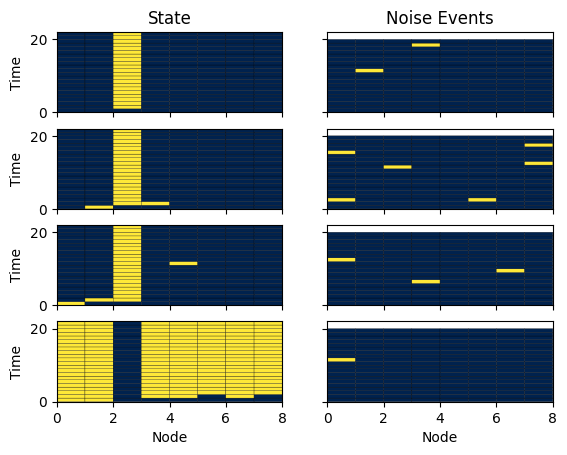

In [44]:
fig, axs = plt.subplots(nrows=4, ncols=2, sharey=True, sharex=True)
lw = 0.2
cm = "cividis"
axs[0, 0].pcolor(example_trajs[:, 0, 0, :], cmap=cm, linewidth=lw, edgecolors="black")
axs[1, 0].pcolor(example_trajs[:, 1, 0, :], cmap=cm, linewidth=lw, edgecolors="black")
axs[2, 0].pcolor(example_trajs[:, 2, 0, :], cmap=cm, linewidth=lw, edgecolors="black")
axs[3, 0].pcolor(example_trajs[:, 3, 0, :], cmap=cm, linewidth=lw, edgecolors="black")

axs[0, 1].pcolor(example_noise[:, 0, 0, :], cmap=cm, linewidth=lw, edgecolors="black")
axs[1, 1].pcolor(example_noise[:, 1, 0, :], cmap=cm, linewidth=lw, edgecolors="black")
axs[2, 1].pcolor(example_noise[:, 2, 0, :], cmap=cm, linewidth=lw, edgecolors="black")
axs[3, 1].pcolor(example_noise[:, 3, 0, :], cmap=cm, linewidth=lw, edgecolors="black")

axs[0, 0].set_title("State")
axs[0, 1].set_title("Noise Events")
axs[-1, 0].set_xlabel('Node')
axs[-1, 1].set_xlabel('Node')

[axs[i, 0].set_ylabel('Time') for i in range(4)]

plt.savefig(os.path.join(plt_save_dir, "and_traj.png"), dpi=400)

In [26]:
importlib.reload(analysis_util)
physical_error_rates = np.linspace(start=0, stop=0.02, num=20)
logical_error_rates = analysis_util.generate_ft_curve(physical_error_rates, cp.array(batched_input_state[:, :best_to_plot, ...]), cp.array(best_functions[:best_to_plot]), cp.array(best_conn[:best_to_plot]), cp.array(best_used_conn[:best_to_plot]), tasks.evaluate_and_task, n_traj=10000)
logical_error_rates = cp.asnumpy(logical_error_rates)

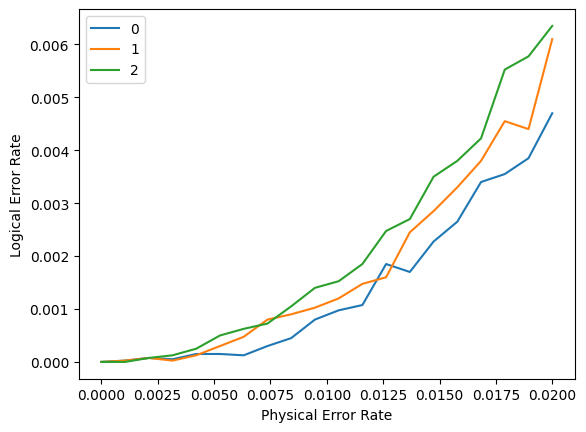

In [45]:
fig, axs = plt.subplots()
logical_error_rates = np.array(logical_error_rates)
for j in range(best_to_plot):
    axs.plot(physical_error_rates, logical_error_rates[:, j], label="{}".format(j))
axs.set_xlabel("Physical Error Rate")
axs.set_ylabel("Logical Error Rate")
axs.legend()

plt.savefig(os.path.join(plt_save_dir, "and_ft.png"), dpi=400)
